# Sprint 3: Transfer Learning from Larger Human Gesture Dataset
Mon 14. - Fri 25. May 2018

In [79]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context = "talk")

from IPython.display import Image, HTML, display

In [60]:
def acc_loss_show(sLogFile, sDescription, nEpoch = 250, colors=None):
    ylim_loss = (0.0,5.0)
    
    print(sDescription)
    
    dfLog = pd.read_csv(sLogFile)
    print("Validation set: max accuracy %.2f | min loss %.3f" % (dfLog.val_acc.max(), dfLog.val_loss.min()))
    #print("\n", dfLog.tail())
    
    if nEpoch == 0: nEpoch = len(dfLog)
    if colors == None: colors = ["b", "g"]
    
    # acc left side
    plt.subplots(figsize=(12,4))
    
    plt.subplot(1, 2, 1) # 1 row x 2 columns, now first subplot 
    plt.plot(dfLog.epoch, dfLog.acc, colors[0], label="Training accuracy")
    plt.plot(dfLog.epoch, dfLog.val_acc, colors[1], label="Validation accuracy")

    plt.xlim((0,nEpoch))
    plt.ylim((0,1))
    plt.legend()
    
    # loss right side
    plt.subplot(1, 2, 2)
    plt.plot(dfLog.epoch, dfLog.loss, colors[0], label="Training loss")
    plt.plot(dfLog.epoch, dfLog.val_loss, colors[1], label="Validation loss")

    plt.xlim((0,nEpoch))
    plt.ylim(ylim_loss)
    plt.legend()
    
    plt.show()
    
    return

## Experiments with Austrian sign language database LedaSila (= sprint 2)

* http://ledasila.aau.at by Alpen Adria Universität Klagenfurt
* 33,300 training videos, 15,700 different signs/words => very long tail
* used top 21 sign/words: 440 videos (min 18 occurences per sign/word)
* Video recognition based on CNN+LSTM: approx 40% accuracy

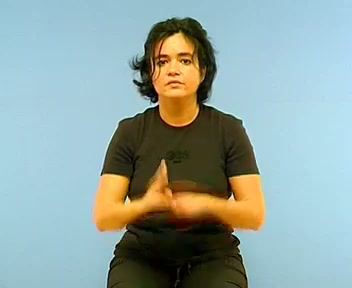

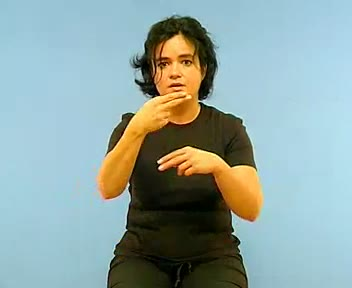

In [78]:
#f0 = Image("data/demo/ledasila-006.jpg", width=200)
#f1 = Image("data/demo/ledasila-009.jpg", width=200)
#display(f0, f1)

display(HTML("<table><tr><td><img src='/image/counts1.png'></td><td><img src='/image/counts2'></td></tr></table>"))


<img src="data/demo/ledasila-006.jpg" width="200"/> | 
<img src="data/demo/ledasila-009.jpg" width="200"/> | 
<img src="data/demo/ledasila-012.jpg" width="200"/> | 
<img src="data/demo/ledasila-014.jpg" width="200"/>

LedaSila-440in21 trained on pretrained CNN + 1 LSTM + 2 dense, lr=1e-5
Validation set: max accuracy 0.47 | min loss 2.597


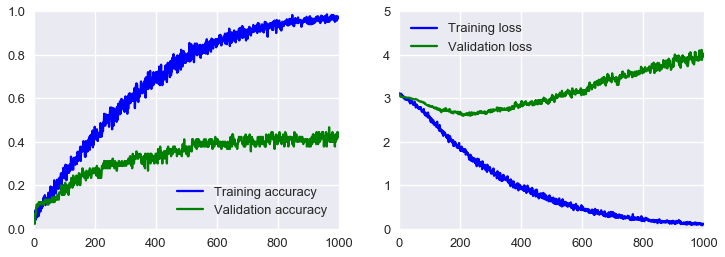

In [61]:
acc_loss_show("../02b-ledasila/log/20180522-1810-lstm-440in21.log", 
    "LedaSila-440in21 trained on pretrained CNN + 1 LSTM + 2 dense, lr=1e-5", 0)

## Larger human gesture dataset ChaLearn

* Isolated Gesture Recognition (ICPR '16) dataset by University of Barcelona http://chalearnlap.cvc.uab.es/dataset/21/description/
* 36,000 labeled videos with 249 human gestures from 21 different individuals. Gestures between 2-10 sec long, similar to sign language
Video recognition based on CNN+LSTM: almost 80% accuracy

<img src="data/demo/chalearn-005.jpg" width="200"/> | 
<img src="data/demo/chalearn-008.jpg" width="200"/> | 
<img src="data/demo/chalearn-012.jpg" width="200"/> | 
<img src="data/demo/chalearn-017.jpg" width="200"/>

ChaLearn trained on pretrained CNN + 2 LSTM + 1 Dense, lr=1e-3
Validation set: max accuracy 0.74 | min loss 0.806


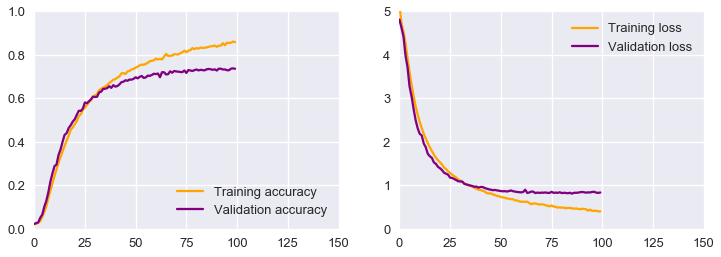

In [70]:
acc_loss_show("../03a-chalearn/log/20180525-1033-lstm-35878in249.acc",
    "ChaLearn trained on pretrained CNN + 2 LSTM + 1 Dense, lr=1e-3", 150, ["orange", "purple"])

Pipeline in a nutshell

* videos sliced to exactly 20 frames (regardless of duration)
* frames (299x299) fed to InceptionV3, exclude last dense layers => feature vector of length 1024 (saved to disc)
* finally training of LSTM layers:

```
keModel = Sequential()
keModel.add(LSTM(1024, return_sequences=True, input_shape=(nFramesNorm, nFeatureLength), dropout=0.5))
keModel.add(LSTM(1024, return_sequences=False, dropout=0.5))
keModel.add(Dense(oFeatureTrain.nLabels, activation='softmax'))
optimizer = Adam(lr=fLearn)
keModel.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
```

## Transfer learning from ChaLearn-36000in250 to LedaSila-440in21

* First train network on ChaLearn, use resulting LSTM model to train on LedaSila dataset (replacing only last dense-softmax layer)
* Training much faster. But i never succeeded in increasing validation accuracy above 40% (although loss decreased)
* Experimented with 
  * finetuning all layers vs freezing (single/all) LSTM layers
  * network architecture: 1-2 LSTM layers, 1-2 Dense layers
  * dropout none to 0.5
  * learning rates

LedaSil-440in221 on ChaLearn with 2 LSTM: finetune entirely, lr=1e-4 => quick start, low loss, acc again <= 40%
Validation set: max accuracy 0.42 | min loss 1.992


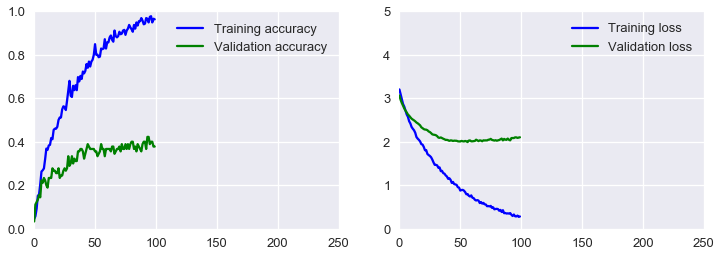

In [71]:
acc_loss_show("../03b-transfer/log/20180525-1303-transfer-440in21.acc", 
    "LedaSil-440in221 on ChaLearn with 2 LSTM: finetune entirely, lr=1e-4 => quick start, low loss, acc again <= 40%")

LedaSil-440in221 on ChaLearn with 2 LSTM: both frozen, lr=1e-4 => :(
Validation set: max accuracy 0.32 | min loss 2.150


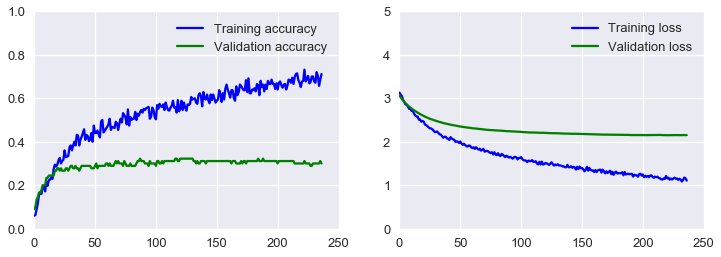

In [69]:
acc_loss_show("../03b-transfer/log/20180525-1320-transfer-440in21.acc", 
    "LedaSil-440in221 on ChaLearn with 2 LSTM: both frozen, lr=1e-4 => :(")

## Why is transfer learning not working?

* While transfer learning for images (trained on ImageNet) is widespread, for videos did not see many examples
* But Google did it in 2016: Training on Youtube-8M and transferring on ActivityNet dataset (20.000 videos) *YouTube-8M: A Large-Scale Video Classification Benchmark*
* I think ChaLearn and LedaSila datasets are similar enough. But perhaps LedaSila simply too small (21 classes with approx 20 videos per class)
* Given my time constraints i will give up on substantially improving the 40% accuracy on LedaSila-440in21 ... and reformulate my project

## Use ChaLearn-36000in250 as sign language video dataset

* I am convinced there is currently no sufficently large dataset with isolated sign language videos for training a deep neural network. Given the success with ChaLearn dataset, probably around 50-100 videos per class would be necessary
* Instead I will continue my project with the ChaLearn dataset as a proxy for sign language videos
* Next sprint will focus on building the video filming/streaming component based on OpenCV, starting from Belals implementation